# Machine Learning #5 - Doğrusal Sınıflandırıcılar, Mantıksal Regresyon, Düzenlileştirme

Merhabalar, Machine Learning serimizin beşincisinde;
* Doğrusal sınıflandırıcıları tanıyacak,
* Mantıksal regresyon ve ilgili kavramları örneklendirerek inceleyeceğiz.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    RocCurveDisplay,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn import svm, datasets

## Mantıksal Regresyon Nedir?

Yazı dizimizin üçüncüsünde, **Doğrusal Regresyon** konusuna değinmiştik. Sonrasında da bu metodu, bir ev fiyatı tahminleyicisi oluşturmak için kullanmıştık. **Doğrusal(Lineer) Regresyon** ile **Mantıksal(Lojistik) Regresyon** kavramları birbirine karıştırılmamalıdır.

**Lojistik Regresyon**, bir **Doğrusal Sınıflandırıcı**'dır. Bir sınıfı belirleyen bir veya daha fazla bağımsız değişken bulunan bir veri kümesini analiz etmek için kullanılan istatistiksel bir yöntemdir. Sonuç, ikili bir değişkenle ölçülür (yalnızca iki olası sonuç vardır). O örnek, aradığımız sınıfa aittir veya değildir(Diğer sınıflardan birine aittir).

Örneğin, ev fiyatı tahminleyicimizi tekrar ele alalım. Elimizde kimi noktasal(örneğin evin oda sayısı), 
kimi sürekli olan(örneğin evin metrekaresi) bir özellik sınıfı mevcuttu. Bu özelliklere göre, yine bir sürekli değişken olan ***ev fiyatı*** özelliğini tahmin etmeye çalışıyorduk.

**Lojistik Regresyon** uygulamalarında da, özellik seti yine sürekli değerler barındırır. Ancak hedefimiz bir **sürekli değişken** yerine bir **sınıf** belirlemektir. Bu sınıfı belirlerken de bir **eşik değer** kullanırız. Örneğin evin fiyatı 50.000 doların altında ise ucuz(y=0 ile temsil edebiliriz) eğer 50.000 doların üzerinde ise pahalı (y=1 ile temsil edebiliriz).

## Karar Sınırı, Doğrusal Sınıflandırıcı, Doğrusal Ayrılabilirlik

Teorik anlatıma devam etmeden önce, bir **Doğrusal Sınıflandırıcı** görsel olarak neye benzer, nasıl çalışır bunu görelim.

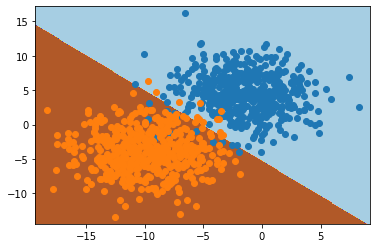

In [4]:
# Kaynak: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.datasets import make_blobs

X_example, y_example = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1, cluster_std=3)

min1, max1 = X_example[:, 0].min()-1, X_example[:, 0].max()+1
min2, max2 = X_example[:, 1].min()-1, X_example[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

model = LogisticRegression()

model.fit(X_example, y_example)

yhat = model.predict(grid)

zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')

for class_value in range(2):
    row_ix = np.where(y_example == class_value)
    plt.scatter(X_example[row_ix, 0], X_example[row_ix, 1], cmap='Paired')

Az sayıda hatalı tahmin edilen örnek olsa da, sınıflandırıcımız bu veri kümesini doğrusal bir çizgiyle iki sınıfa ayırabildi. Bu, sınıflandırıcımızın bir **Doğrusal Sınıflandırıcı**, veri kümemizin de **Doğrusal Ayrılabilir** olduğu anlamına gelir.

## Mantıksal Regresyon Uygulaması

Uygulama için, bir telekom şirketinin müşteri veri setini ele alacak ve hangi müşterinin **churn** edip etmediğini tahminleyeceğiz.

**churn**: Müşterinin artık o şirketin müşterisi olmaması anlamına gelir.

Veri seti kaynağı: https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset

In [7]:
df = pd.read_csv("customer_churn.csv")

Veri kümemizi değişkene atadıktan sonra, klasik olarak keşifsel veri analizi kısımlarıyla devam ediyoruz.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Call  Failure            3150 non-null   int64
 1   Complains                3150 non-null   int64
 2   Subscription  Length     3150 non-null   int64
 3   Charge  Amount           3150 non-null   int64
 4   Seconds of Use           3150 non-null   int64
 5   Frequency of SMS         3150 non-null   int64
 6   Distinct Called Numbers  3150 non-null   int64
 7   Age                      3150 non-null   int64
 8   Churn                    3150 non-null   int64
dtypes: int64(9)
memory usage: 221.6 KB


Veri setimiz, bir telekom müşterisine ait olabilecek ne kadar süredir abone olduğu, SMS sıklığı, yaptığı aramaların sayısı, fatura tutarının ne kadar büyük/küçük olduğu gibi özellikleri içeriyor. Buradaki **Churn** özelliği, bizim hedef değişkenimizdir. Modelimizden bu değişkeni y=0(Hala şirketin müşterisi) veya y=1(Artık müşteri değil) olarak tahminlemesini isteyeceğiz.

In [9]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of SMS,Distinct Called Numbers,Age,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,73.174921,23.509841,30.998413,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,112.237560,17.217337,8.831095,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,6.000000,10.000000,25.000000,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,21.000000,21.000000,30.000000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,87.000000,34.000000,30.000000,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,522.000000,97.000000,55.000000,1.000000


Veri setimizi ön işleme adımında, scale etmeyi atlamamak gerekir. Çünkü, özelliklerin **maximum**, **mean** gibi değerlerini kıyasladığımızda, birbirlerinden oldukça farklı olabildiklerini görüyoruz.

In [56]:
X = df.iloc[:, 0:8]  
y = df["Churn"]  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)

sc = StandardScaler().fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [57]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'random_state': [42],
              'penalty': ['l2']
             }

lr = LogisticRegression()
searcher = GridSearchCV(lr, parameters)

searcher = searcher.fit(X_train_scaled, y_train)
y_pred = searcher.predict(X_test_scaled)

print("Best CV params", searcher.best_params_)

Best CV params {'C': 0.1, 'penalty': 'l2', 'random_state': 42}


Grid search ile en uygun **C** parametresinin **0.1** olduğunu gördük. Peki regresyon modelimiz buna nasıl karar verir? Görselleştirerek görelim.

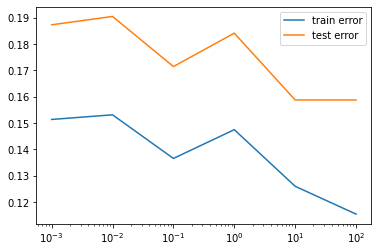

In [58]:
train_errs = list()
test_errs = list()
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for C_value in C_values:
    lr = LogisticRegression(C=C_value)
    lr.fit(X_train, y_train)
    
    train_errs.append( 1.0 - lr.score(X_train, y_train) )
    test_errs.append( 1.0 - lr.score(X_test, y_test) )
    
plt.semilogx(C_values, train_errs, C_values, test_errs)
plt.legend(("train error", "test error"))
plt.show()

Hem train, hem de test hatalarını **C** parametresinin değerine göre sıraladığımızda ilk ve en büyük aşağı yönlü kırılmanın **0.1** değerinde olduğunu görüyoruz. Bundan sonra doğruların eğimi yeniden yükselmeye başlıyor. Bundan dolayı, optimum **C** parametre değerinin **0.1** olduğunu söyleyebiliriz.

En uygun parametreleri bulmayı denerken **'random_state'** ve **'penalty'** değerlerini kendimiz belirledik. Ancak, **'C'** değeri için toplam 6 deneme yaptık ve en uygun değeri **0.1** olarak belirledik. Peki, nedir bu **C** parametresi?

## Lojistik Regresyonda Düzenleme(Regülarizasyon) Etkisi

**C** parametresi, **scikit-learn** kütüphanemiz için regülarizasyonun tersini ifade eder. **Daha büyük C daha az düzenleme, daha küçük C daha fazla düzenleme anlamına gelir**.

In [70]:
lr_weak_reg = LogisticRegression(C=10000)
lr_strong_reg = LogisticRegression(C=0.01)

lr_weak_reg.fit(X_train_scaled, y_train)
lr_strong_reg.fit(X_train_scaled, y_train)

print(lr_weak_reg.score(X_train_scaled, y_train))
print(lr_strong_reg.score(X_train_scaled, y_train))

0.9033509700176366
0.9015873015873016


Daha önceki yazılarda, regülarizasyonun "büyük katsayılar için bir cezalandırma işlevi" olduğundan bahsetmiştik. **l1** ve **l2** regülarizasyonlarını da ayrı ayrı inceleyerek özellik seçimine nasıl etki ettiğini gözlemlemiştik.

Burada da, iki farklı **C** değeri için eğitim hatalarını karşılaştırdık. Düzenlileştirme arttıkça(Daha küçük C değeri için) eğitim başarısının düştüğünü gördük. Cezalandırma işlevinin gereğinden fazla kullanılması, bazı önemli katsayıların da olması gerekenden daha küçük olması ve daha işlevsiz kalmasına yol açar. Bu da eğitim başarısını düşürür.

In [71]:
print(lr_weak_reg.score(X_test_scaled, y_test))
print(lr_strong_reg.score(X_test_scaled, y_test))

0.8793650793650793
0.8920634920634921


Test verisi üzerinde bu etkiyi incelediğimizde ise, yüksek regülarizasyonun test başarısını yükselttiğini görüyoruz. Bunun sebebi de, daha önce değindiğimiz gibi işlevsiz özellikler için katsayıların sıfırlanabilmesi ve bunun performansı artırmasıdır.

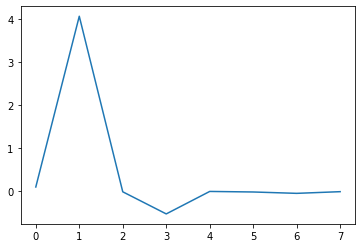

In [76]:
lr_L1 = LogisticRegression(penalty='l1', solver='liblinear') #solver'ı defaultta bırakırsanız hata alırsınız.
lr_L1.fit(X_train, y_train)
plt.plot(lr_L1.coef_.flatten())

Düzenleme için **l1** kullandığımızda işimize yaramayacak pek çok özelliğin katsayısının sıfıra eşitlendiğini görüyoruz. Bu, test başarısını yükseltir.

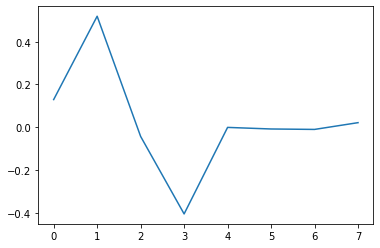

In [77]:
lr_L2 = LogisticRegression() #varsayılan olarak 'l2'dir.
lr_L2.fit(X_train, y_train)
plt.plot(lr_L2.coef_.flatten())

**l2** ise, bir regülarizasyondan beklediğimiz şekilde katsayıları küçültür.

In [78]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8920634920634921


Bu regülarizasyonla model başarısının %89.2 olduğunu gördük. Son olarak ROC eğrisini de çizdirerek bu kısmı noktalayalım.

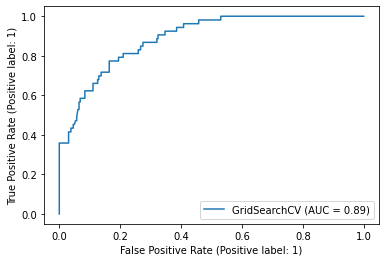

In [81]:
RocCurveDisplay.from_estimator(searcher, X_test_scaled, y_test)

Bir ROC eğrisi (Receiver Operating Characteristic), model başarımını görmenin bir diğer yoludur. Gerçekten pozitif tahmin edilen değerler(True Positive) ile hatalı olarak pozitif(False Positive) tahmin edilen değerlerin bir görselleştirmesidir. İdeal olarak sol üst köşeye yaklaşan bir eğri görmek isteriz.

Bizim örneğimiz için, sol tarafta doğru tahmin edilen churn eden müşterileri, sağ eksende de churn etmediği halde churn olarak tahmin edilen müşterileri görüyoruz. AUC(Area Under Curve) değerinin **accuracy** ile aynı olduğuna dikkat edin.

Sonraki yazılarımızda görüşmek üzere.